# 1. Build your own convolutional neural network using pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='C:/Users/76373/OneDrive/Desktop/Dog_heart/Train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):  
        self.root_dir = root  
        self.transform = transform
        self.files = [os.path.join(root, f) for f in os.listdir(root) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)


test_dataset = CustomDataset(root='C:/Users/76373/OneDrive/Desktop/Dog_heart/Valid', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)


In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class CustomTestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root_dir = root  
        self.transform = transform
        self.files = [os.path.join(root, f) for f in os.listdir(root) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)  

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = CustomTestDataset(root='C:/Users/76373/OneDrive/Desktop/Dog_heart/Test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

model.train()  
for epoch in range(30):  
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1} finished with loss: {loss.item()}')

torch.save(model.state_dict(), 'C:/Users/76373/OneDrive/Desktop/Dog_heart/best_model.pt')

Epoch 1 finished with loss: 0.9594834446907043
Epoch 2 finished with loss: 1.1376224756240845
Epoch 3 finished with loss: 0.9529330730438232
Epoch 4 finished with loss: 0.886773407459259
Epoch 5 finished with loss: 0.7990109324455261
Epoch 6 finished with loss: 0.7132468223571777
Epoch 7 finished with loss: 0.7750096917152405
Epoch 8 finished with loss: 0.7516686916351318
Epoch 9 finished with loss: 0.7719523310661316
Epoch 10 finished with loss: 0.7797760963439941
Epoch 11 finished with loss: 0.7548708319664001
Epoch 12 finished with loss: 0.6317470669746399
Epoch 13 finished with loss: 0.7447417378425598
Epoch 14 finished with loss: 0.4936971962451935
Epoch 15 finished with loss: 0.8423912525177002
Epoch 16 finished with loss: 0.49236369132995605
Epoch 17 finished with loss: 0.4949711561203003
Epoch 18 finished with loss: 0.43415847420692444
Epoch 19 finished with loss: 0.422872394323349
Epoch 20 finished with loss: 0.47633838653564453
Epoch 21 finished with loss: 0.76893550157547
Ep

In [ ]:
from PIL import Image

model.eval()  
with torch.no_grad():
    for inputs, file_names in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for file_name, pred in zip(file_names, predicted):
            print(f"File: {file_name}, Predicted label: {pred.item()}")

In [ ]:
import pandas as pd

model.eval()  
predictions = []
file_names_list = []

with torch.no_grad():
    for inputs, file_names in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())  
        file_names_list.extend(file_names)

results_df = pd.DataFrame({
    'FileName': file_names_list,
    'Prediction': predictions
})

results_df.to_csv('C:/Users/76373/OneDrive/Desktop/Dog_heart/predictions.csv', index=False, header=False)

# 3. Evaluate your model using the developed software

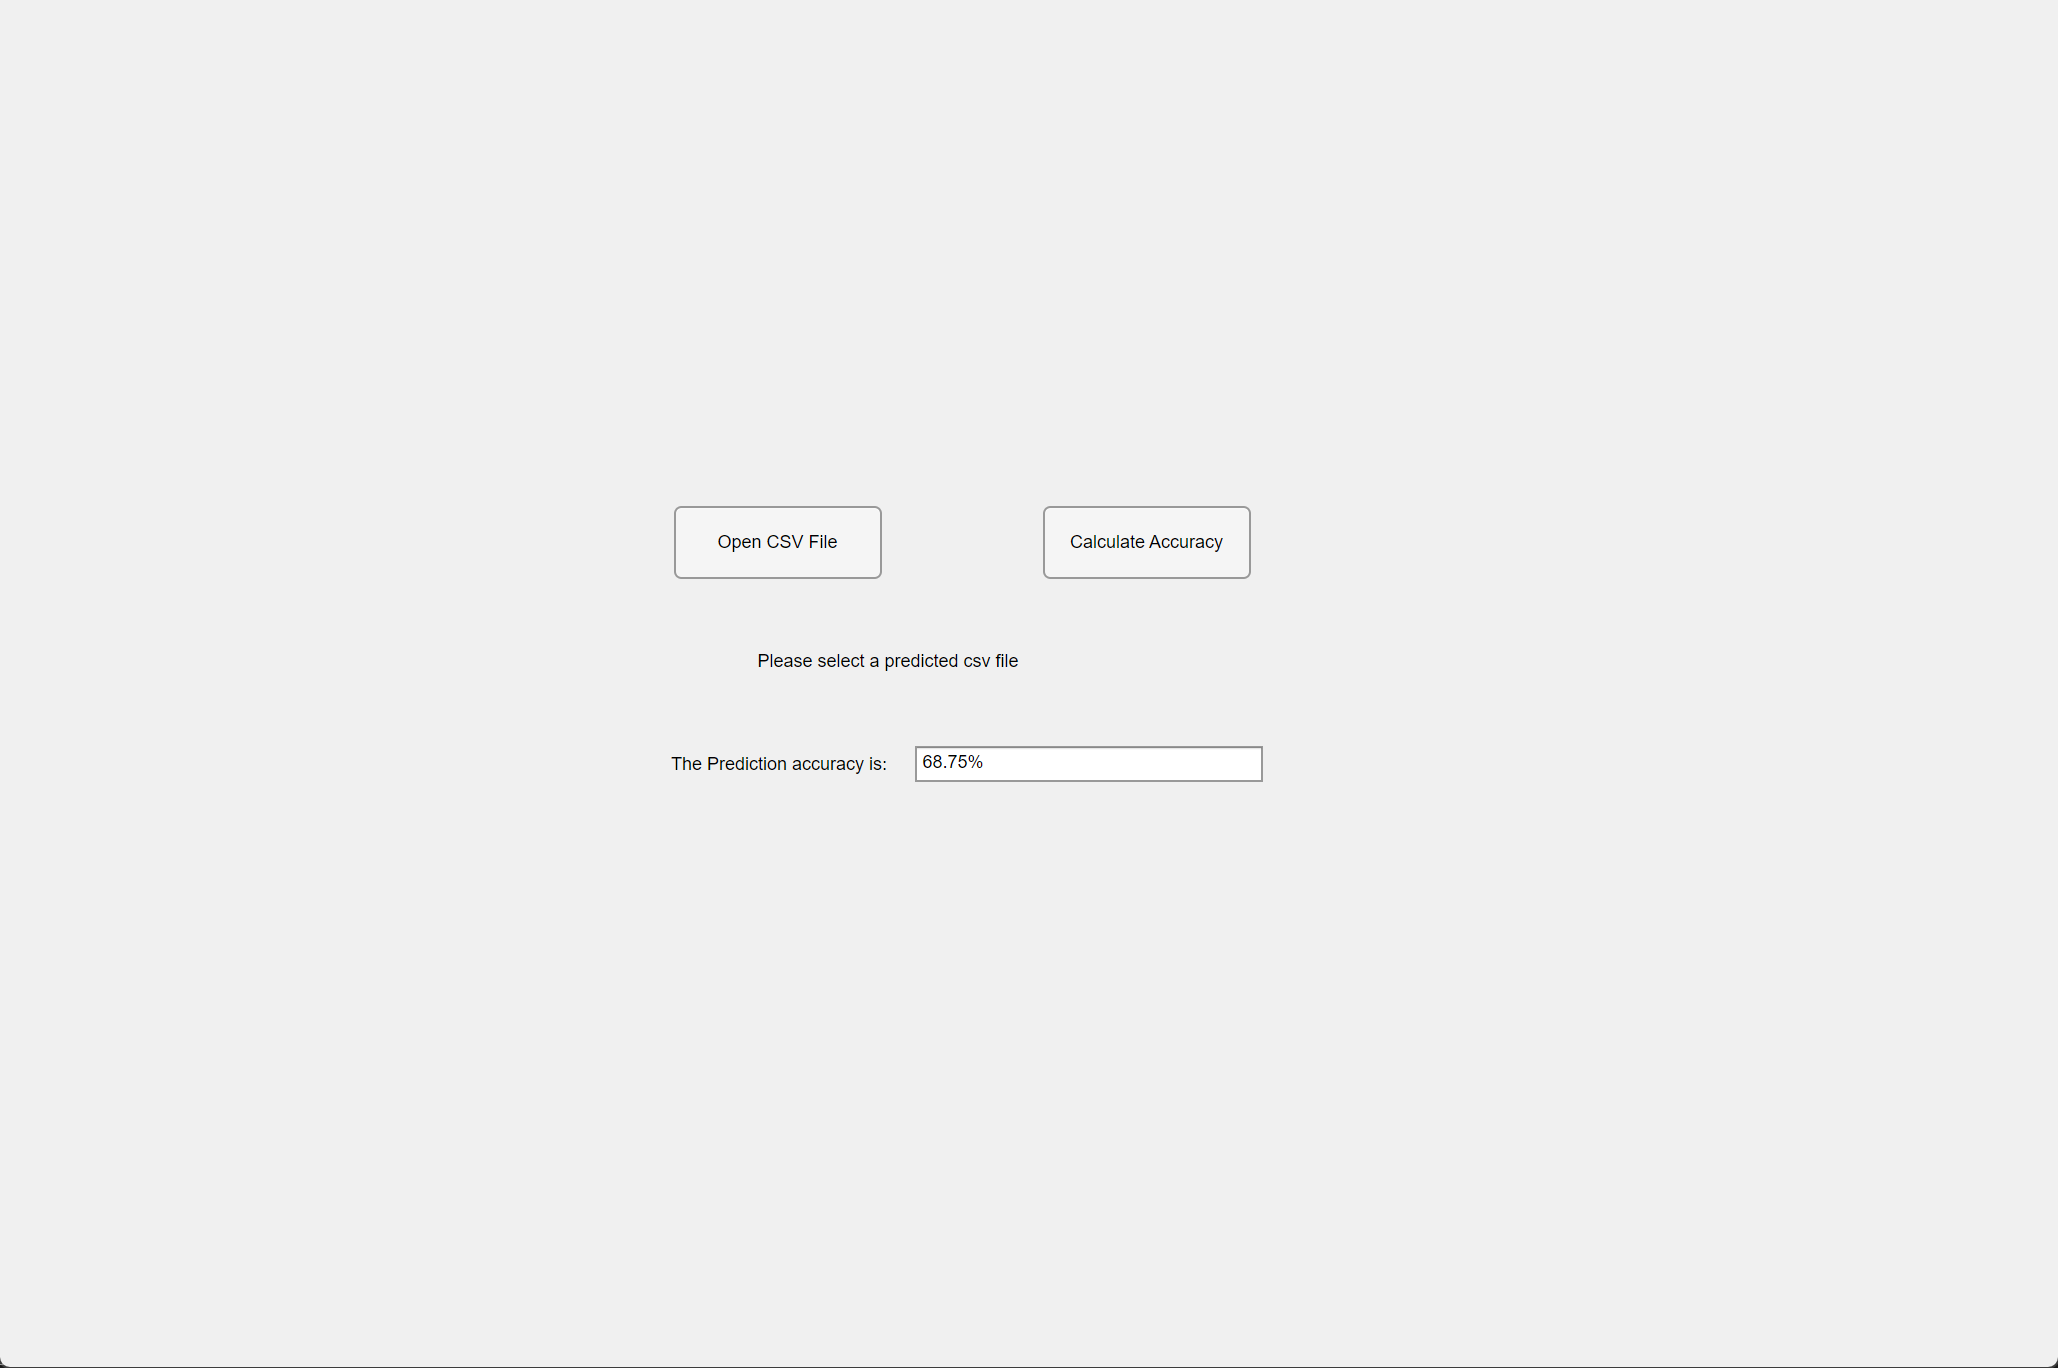

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

Comparison with RVT Paper

My model, which leverages a simple convolutional neural network (CNN) to classify dog cardiomegaly, achieved an accuracy of 68.75%. This result falls short of the 75% accuracy reported for the VGG16 model in the RVT paper, which discusses the use of regressive vision transformers to improve diagnostic alignments. Unlike the advanced techniques employed in the RVT study, my approach was based on a straightforward CNN architecture without the integration of vision transformers. Considering this, further enhancements might include exploring transformer-based models or expanding the training dataset to improve the model’s performance. Additionally, adapting methodologies like few-shot learning, as suggested in the RVT paper, could be beneficial for enhancing generalization from limited data.

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

Paper link: https://www.researchgate.net/publication/390170024_Dog_Heart_Image_Classification_Using_CNN_with_Data_Augmentation_and_Model_Optimization

GitHub link: https://github.com/763730440/dog-heart-classification.git



# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 75 % -->10 points
     < 55 % -->0 points
     >= 55 % & < 75% --> 0.5 point/percent
     

(6). Discussion - 10 points